- random seed to generate network and design locations (R)
- random seed to generate gaussian field covariates (Python)
- random seed to generate response, sim_river and sim_euc (R)
- random seed to generate anomalies (Python)

Then, the model is run

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from gnnad.graphanomaly import GNNAD
from gnnad.generate import GenerateGaussian, GenerateAnomaly, pivot_dataframe
from gnnad.plot import plot_test_anomalies

seeds = [151, 383, 432, 234, 231, 12, 304, 994, 67, 533]
response_cols = ['sim_euc', 'sim_river']

rerun_gaussian = False

```
library(SSN)
library('dplyr')

# network variables, fixed
n.segments = 300
n.sites = 40

# change seed, the generation of new networks and design
seed.networks=c(151, 383, 432, 234, 231, 12, 304, 994, 67, 533)

generate.network <- function(ssn.obj.path, n.segments, n.sites){
  if(dir.exists(ssn.obj.path)) {
    # read in empty network object
    n1 <- importSSN(ssn.obj.path)
  } else {
    # create network
    n1 <- createSSN(c(n.segments), 
                    obsDesign = binomialDesign(n.sites),
                    path=ssn.obj.path, importToR = TRUE, treeFunction = iterativeTreeLayout)
    # create distances file
    createDistMat(n1, o.write=TRUE)
  }
  return(n1)
}

write.coords.csv <- function(seed.network){
  
  ssn.obj.path = paste('./nsegments',n.segments, 'nsites', n.sites, 'seed',seed.network,'.ssn',sep='')
  set.seed(seed.network)
  
  # fix network, fix locations on it
  network <- generate.network(ssn.obj.path, n.segments, n.sites)
  
  # get locations
  obs_coord <- data.frame(network@obspoints@SSNPoints[[1]]@point.coords)
  obs_coord$pid <- as.numeric(rownames(obs_coord))
  
  write.csv(obs_coord, paste0('obs_coord',seed.network,'.csv'))
  
}

for(seed.network in seed.networks){
  write.coords.csv(seed.network)
}
```

In [2]:
if rerun_gaussian:
       for seed in seeds:
              # read in locations of network
              coords = pd.read_csv('R/obs_coord{}.csv'.format(seed), index_col=0)
              coords['x'] = coords['coords.x1'].round(1)
              coords['y'] = coords['coords.x2'].round(1)

              # create a field of the right size
              x_field = np.arange(np.floor(min(coords.x)), np.ceil(max(coords.x)), 0.1)
              y_field = np.arange(np.floor(min(coords.y)), np.ceil(max(coords.y)), 0.1)

              # get locations of sites
              for i in coords.index:
                     coords.loc[i, 'x_idx'] = np.where(np.isclose(x_field, coords.x[i]))[0][0]
                     coords.loc[i, 'y_idx'] = np.where(np.isclose(y_field, coords.y[i]))[0][0]

              # generate data
              gengauss = GenerateGaussian(T=4000, x_lim=(np.floor(min(coords.x)),
                                                 np.ceil(max(coords.x))),
                                          y_lim=(np.floor(min(coords.y)),
                                                 np.ceil(max(coords.y))),
                                          x_idxs=list(coords.x_idx.astype(int).values),
                                          y_idxs=list(coords.y_idx.astype(int).values),
                                          ids=list(coords.pid.values),
                                          pivot_df=False,
                                          )
              X = gengauss.generate()
              X.to_csv('R/obs_X{}.csv'.format(seed))

       gengauss.field_plot(figsize=(8,5))

```
for(seed.network in seed.networks){
  ssn.obj.path = paste('./nsegments',n.segments, 'nsites', n.sites, 'seed',seed.network,'.ssn',sep='')
  
  # add locations to observation data
  network <- generate.network(ssn.obj.path, n.segments, n.sites)
  obs_df <- getSSNdata.frame(network, "Obs")
  
  obs_coord <- read.csv(paste0('obs_coord',seed.network,'.csv'))
  obs_df <- obs_df %>% left_join(obs_coord, by = c("pid"), keep = FALSE)

  # read in gaussian field covariates
  X1_all <- read.csv(paste0('obs_X',seed.network,'.csv'))
  names(X1_all) <- c('', 't', 'pid', 'X1')
  set.seed(seed.network + 4229)
  
  # Generate SimRiv response
  coefficients = sample(1:10, 2)
  CorModels = c("LinearSill.tailup")
  CorParms = c(sample(1:5, 1), sample(5:15, 1), runif(1, 0, 1))
  
  sim_values <- c()
  for(t in 0:max(X1_all$t)){
    
    X1 <- X1_all[X1_all$t==t,'X1']
    sim.out <- SimulateOnSSN(network,
                             ObsSimDF = obs_df,
                             formula = ~ X1,
                             coefficients = coefficients,
                             CorModels = CorModels,
                             use.nugget = TRUE,
                             CorParms = CorParms,
                             addfunccol = "addfunccol")
    
    simDFobs <- getSSNdata.frame(sim.out$ssn.object, "Obs")
    sim_values <- c(sim_values, simDFobs$Sim_Values)
  }
  X1_all$sim_river = sim_values
  
  # Generate SimEuc response
  euc_coefficients = sample(1:10, 2)
  euc_CorModels = c("Exponential.Euclid")
  euc_CorParms = c(sample(1:5, 1), sample(5:15, 1), runif(1, 0, 1))
  
  sim_values <- c()
  for(t in 0:max(X1_all$t)){
    
    X1 <- X1_all[X1_all$t==t,'X1']
    sim.out <- SimulateOnSSN(network,
                             ObsSimDF = obs_df,
                             formula = ~ X1,
                             coefficients = euc_coefficients,
                             CorModels = euc_CorModels,
                             use.nugget = TRUE,
                             CorParms = euc_CorParms,
                             addfunccol = "addfunccol")
    
    simDFobs <- getSSNdata.frame(sim.out$ssn.object, "Obs")
    sim_values <- c(sim_values, simDFobs$Sim_Values)
  }
  X1_all$sim_euc = sim_values
  
  # save response variables
  write.csv(X1_all,paste0('sim_data',seed.network,'.csv'))
  }
```

In [3]:
import random
from sklearn.metrics import confusion_matrix

cols = ['seed', 'model', 'simulation', 'tn', 'fp', 'fn', 'tp']
all_results = pd.DataFrame(columns=cols)

rerun_models = False

if rerun_models:
    for response_col in response_cols:
        for seed in seeds:
            # read in simulated data from SSN
            X = pd.read_csv('R/sim_data{}.csv'.format(seed), index_col=0).rename(columns={'pid': 'id'})
            X = pivot_dataframe(X[['t', 'id', response_col]])

            # split train test
            X_train, X_test = train_test_split(X, shuffle=False)

            # generate anomalies on test set, instantiate class
            random.seed(seed)
            var_scale=random.sample(range(2,8), k=1)[0]
            drift_delta=random.uniform(0.85, 1.5)
            anoms = GenerateAnomaly(X_test, var_scale=var_scale, drift_delta=drift_delta)

            # generate variability
            lam = random.sample(range(5,15), k=1)[0]
            prop_anom = random.uniform(0.10, 0.30)
            #prop_anom = random.uniform(0.01, 0.05)
            X_test = anoms.generate(anoms.variability, lam = lam, prop_anom = prop_anom, seed=seed + 11)

            # generate drift
            lam = random.sample(range(5,15), k=1)[0]
            prop_anom = random.uniform(0.10, 0.30)
            X_test = anoms.generate(anoms.drift, lam = lam, prop_anom = prop_anom, seed=seed + 234)
            y_test = anoms.get_labels()

            # run model
            model = GNNAD(threshold_type="max_validation", slide_win=3, topk=5)
            fitted_model = model.fit(X_train, X_test, y_test)

            # GDN
            tn, fp, fn, tp = confusion_matrix(fitted_model.test_labels, fitted_model.pred_labels).ravel()
            all_results = pd.concat([all_results, pd.DataFrame([[seed, 'GDN', response_col, tn, fp, fn, tp]],columns=cols)])

            # GDN+, sensor thresholds
            preds = fitted_model.sensor_threshold_preds(tau = 99.999)
            tn, fp, fn, tp = confusion_matrix(fitted_model.test_labels, preds).ravel()
            all_results = pd.concat([all_results, pd.DataFrame([[seed, 'GDN+', response_col, tn, fp, fn, tp]],columns=cols)])
    all_results = pd.read_csv('R/replication_study.csv', index_col=0)

In [5]:
df = all_results.set_index(['simulation', 'model']).drop(['seed'])
df

seed   tn   fp   fn   tp
simulation model                          
sim_euc    GDN     151  603    8  379    7
           GDN+    151  478  133  270  116
           GDN     383  589   42  253  113
           GDN+    383  505  126  179  187
           GDN     432  608   22  319   48
           GDN+    432  432  198  190  177
           GDN     234  594   13  357   33
           GDN+    234  467  140  255  135
           GDN     231  676   10  274   37
           GDN+    231  600   86  219   92
           GDN      12  581   59  178  179
           GDN+     12  509  131  147  210
           GDN     304  584   24  295   94
           GDN+    304  476  132  228  161
           GDN     994  610    1  382    4
           GDN+    994  552   59  322   64
           GDN      67  559    1  428    9
           GDN+     67  446  114  314  123
           GDN     533  673   44  229   51
           GDN+    533  554  163  165  115
sim_river  GDN     151  577   34  309   77
           GDN+    151  479  132  238  148
           GDN     383  587   44  241  125
           GDN+    383  538   93  188  178
           GDN     432  607   23  317   50
           GDN+    432  415  215  166  201
           GDN     234  571   36  258  132
           GDN+    234  464  143  167  223
           GDN     231  656   30  221   90
           GDN+    231  534  152  174  137
           GDN      12  637    3  351    6
           GDN+     12  542   98  297   60
           GDN     304  592   16  307   82
           GDN+    304  494  114  186  203
           GDN     994  609    2  380    6
           GDN+    994  491  120  294   92
           GDN      67  558    2  421   16
           GDN+     67  476   84  350   87
           GDN     533  692   25  129  151
           GDN+    533  602  115   78  202

C:\Users\n10907700\AppData\Local\Temp\ipykernel_2124\428282824.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('replication_study.pdf',bbox_inches='tight')
C:\Users\n10907700\AppData\Local\Temp\ipykernel_2124\428282824.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('replication_study.pdf',bbox_inches='tight')
c:\Users\n10907700\Anaconda3\envs\gnnad\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


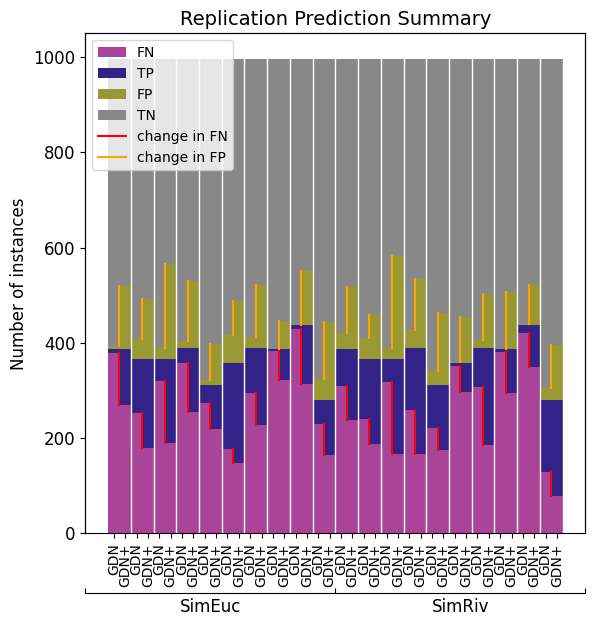

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

width = 0.1
ind = np.arange(0, len(df)*width, width) # the x locations for the groups

fig = plt.figure(figsize=(5,5))
fig.set_tight_layout(True)
ax = fig.add_axes([0,0,1,1])

fn = df.fn.values
tp = df.tp.values
fp = df.fp.values
tn = df.tn.values

ax.bar(ind, fn, width, color='#AA4499', label='FN')
ax.bar(ind, tp, width, bottom=fn, color='#332288', label='TP')
ax.bar(ind, fp, width, bottom=fn+tp, color='#999933', label='FP')
ax.bar(ind, tn, width, bottom=fp+fn+tp, color='#888888', label='TN')
ax.set_ylabel('Number of instances' , fontsize=12)
ax.set_title('Replication Prediction Summary', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(np.tile(['GDN', 'GDN+'], int(len(df)/2)),rotation=90)
#ax.legend(labels=['FN', 'TP', 'FP', 'TN'], fontsize=10)

# for i in range(len(df)):
#     if i%2==0:
#         ax.plot(ind[i:i+2], fn[i:i+2]+tp[i:i+2], c='black')

for i in range(len(df)):
    if i%2==0:
        if i==0:
            ax.plot([np.mean(ind[i:i+2]),np.mean(ind[i:i+2])], fn[i:i+2]+tp[i:i+2]+fp[i:i+2], c='orange', label="change in FP")
        else:
            ax.plot([np.mean(ind[i:i+2]),np.mean(ind[i:i+2])], fn[i:i+2]+tp[i:i+2]+fp[i:i+2], c='orange')

for i in range(len(df)):
    if i%2==0:
        if i==0:
            ax.plot([np.mean(ind[i:i+2]),np.mean(ind[i:i+2])], fn[i:i+2], c='red', label="change in FN")
        else:
            ax.plot([np.mean(ind[i:i+2]),np.mean(ind[i:i+2])], fn[i:i+2], c='red')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [2,3,4,5,1,0]

#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper left") 

# Second X-axis
ax2 = ax.twiny()
ax2.spines["bottom"].set_position(("axes", -0.12))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.set_xticks([0.0, 0.5, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.25, 0.75]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['SimEuc', 'SimRiv']))
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax.tick_params(axis='y', labelsize= 12)

#ax.vlines(np.array([2-(0.0125*4)]), ymin=0, ymax=1000, colors=['white'])
ax.vlines(ind[1::2]+0.05, ymin=0, ymax=1000, colors='white',linewidth=1)

#plt.show()
#plt.autoscale()
#plt.savefig('replication_study.pdf',bbox_inches='tight')
